# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# sklearn
from sklearn.model_selection import train_test_split
import numpy as np

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Input, Conv2D, Flatten, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy, CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import to_categorical
import datetime
import pandas as pd

In [3]:
from neuralart.data import *

In [4]:
# Movement selection

merge_mov_1={'abstract_expressionism': 'abstract',
                 'action_painting': 'abstract',
                 'analytical_cubism': 'cubism',
                 'art_nouveau_modern': None,
                 'baroque': None,
                 'color_field_painting': 'color_field_painting',
                 'contemporary_realism': None,
                 'cubism': 'cubism',
                 'early_renaissance': 'renaissance',
                 'expressionism': 'expressionism',
                 'fauvism': None,
                 'high_renaissance': 'renaissance',
                 'impressionism': 'impressionism',
                 'mannerism_late_renaissance': None,
                 'minimalism': None,
                 'naive_art_primitivism': None,
                 'new_realism': None,
                 'northern_renaissance': 'renaissance',
                 'pointillism': None,
                 'pop_art': None,
                 'post_impressionism': None,
                 'realism': 'realism',
                 'rococo': None,
                 'romanticism': 'romanticism',
                 'symbolism': None,
                 'synthetic_cubism': 'cubism',
                 'ukiyo_e': None}

df_mov1=df.replace(merge_mov_1.keys(),merge_mov_1.values())
df_mov1=df_mov1[df_mov1['movement'].notnull()]
df_mov1.shape

NameError: name 'df' is not defined

In [11]:

MAIN_PATH = "../raw_data/wikiart/" # Path to the directory which contains CSVs and the folder 'dataset'
IMAGES = "dataset"
CSV_NAME = "wikiart-movement-genre_True-class_8-merge_mov-1-n_100_max.csv" # Nwikiart-movement-genre_True-class_3-merge_test1-n_1000_max.csvme of the CSV we want to use
NUM_MOVEMENT = 8 # Number of movements to classify
NUM_GENRE = 10 # Number of genres to classify
IMG_HEIGHT = IMG_WIDTH = 224 # Model's inputs shapes

USER = "gregoire" # Choose between 'common', 'pablo', 'quentin', 'gregoire', 'alex'
MODEL_NAME = "Custom v1" # Set the name of the model 

'''----------------------------------
Load the CSV
----------------------------------'''
BATCH_SIZE = 32
EPOCHS = 50


'''----------------------------------
Load the CSV
----------------------------------'''
raw_df = pd.read_csv(MAIN_PATH + CSV_NAME)
df = raw_df.iloc[:, 0:3]
assert type(df) == type(pd.DataFrame()) # Check if we created a dataframe
assert df.iloc[:, 1].nunique() ==  NUM_MOVEMENT # Check if we have the correct number of movements
assert df.iloc[:, 2].nunique() ==  NUM_GENRE # Check if we have the correct number of genres

print(f"Number of images : {df.shape[0]}")

'''----------------------------------
OHE
----------------------------------'''

df_genre_ohe = pd.get_dummies(df['genre'])
df_mov_ohe = pd.get_dummies(df['movement'])

df = pd.concat([df,df_genre_ohe, df_mov_ohe], axis=1)


Number of images : 800


In [12]:
df.head()

,file_name,movement,genre,abstract_painting,cityscape,genre_painting,illustration,landscape,nude_painting,portrait,...,sketch_and_study,still_life,abstract,color_field_painting,cubism,expressionism,impressionism,realism,renaissance,romanticism
0,abstract-expressionism_esteban-vicente_copla-1...,abstract,abstract_painting,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,abstract-expressionism_sam-francis_untitled-sf...,abstract,abstract_painting,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,abstract-expressionism_brice-marden_cyprian-ev...,abstract,abstract_painting,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,abstract-expressionism_audrey-flack_still-life...,abstract,still_life,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4,action-painting_jackson-pollock_black-white-nu...,abstract,abstract_painting,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [23]:
'''----------------------------------
Train, test, val split
----------------------------------'''
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True)
# assert type(df_train) == type(pd.DataFrame()) # Check if we created dataframes
# assert type(df_test) == type(pd.DataFrame())
# assert type(df_val) == type(pd.DataFrame())

print(f"Number of images in train set : {df_train.shape[0]}")
print(f"Number of images in val set : {df_val.shape[0]}")
print(f"Number of images in test set : {df_test.shape[0]}")
print('\n')

'''----------------------------------
Baselines
----------------------------------'''

#baseline calculated on occurence in train set 
baseline_mov=dict(df_train.groupby(by='movement')['file_name'].count()/df_train.shape[0])
baseline_gen=dict(df_train.groupby(by='genre')['file_name'].count()/df_train.shape[0])

assert sum(baseline_mov.values())==1
assert sum(baseline_gen.values())==1


Number of images in train set : 512
Number of images in val set : 128
Number of images in test set : 160




In [24]:
'''----------------------------------
Setup outputs columns
----------------------------------'''
#assert len(list(df.columns[1:])) == 2 # Check if we have two outputs columns
#columns=list(df.columns[1:])

columns_genre = list(df_genre_ohe.columns)
columns_mov = list(df_mov_ohe.columns)
columns = columns_mov + columns_genre 

'''----------------------------------
Train ImageDataGenerator
----------------------------------'''
train_datagen = ImageDataGenerator( # This generator is only used to train data because it has data augmentation and we do not want to augment data from the test or val set
    rescale=1./255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    dtype=tf.float32
    )

#assert type(train_datagen) == type(ImageDataGenerator())

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, # Dataset used to get the path (column filename) and the linked outputs
    directory=MAIN_PATH + IMAGES, # Path to the images
    x_col="file_name", # Column with the name of the images that the generator will get from the directory
    y_col=columns, # Columns with the output of the images that the generator will get from the csv
    batch_size=BATCH_SIZE,
    seed=None,
    shuffle=True,
    class_mode="raw", # numpy array of values in y_col columns
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize the images to the input shape of the model
    data_format='channels_last'
    ) 


'''----------------------------------
Test and Val ImageDataGenerator
----------------------------------'''
test_val_datagen = ImageDataGenerator(  # We use a new generator without data augmentation
    rescale=1./255
    )

val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=df_val, 
    directory=MAIN_PATH + IMAGES,
    x_col="file_name",
    y_col=columns,
    batch_size=BATCH_SIZE,
    seed=None,
    shuffle=False,
    class_mode="raw", 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    data_format='channels_last'
    )

test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=MAIN_PATH + IMAGES,
    x_col="file_name",
    batch_size=1,
    seed=None,
    shuffle=False,
    class_mode=None, # No targets are returned (the generator will only yield batches of image data, which is useful to use in model.predict()
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    data_format='channels_last'
    )


#assert type(test_val_datagen) == type(ImageDataGenerator())

Found 512 validated image filenames.
Found 128 validated image filenames.
Found 160 validated image filenames.


# Baseline

## Occurence Baseline

In [27]:
baseline_mov=dict(df_train.groupby(by='movement')['file_name'].count()/df_train.shape[0])
baseline_mov

{'abstract': 0.134765625,
 'color_field_painting': 0.1328125,
 'cubism': 0.119140625,
 'expressionism': 0.134765625,
 'impressionism': 0.12109375,
 'realism': 0.123046875,
 'renaissance': 0.123046875,
 'romanticism': 0.111328125}

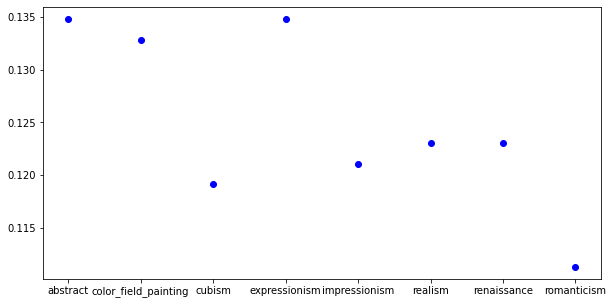

In [31]:
import matplotlib.pyplot as plt
mov_bas=pd.DataFrame(df_train.groupby(by='movement')['file_name'].count()/df_train.shape[0]).reset_index()
plt.figure(figsize=(10, 5))
plt.scatter(x=mov_bas['movement'],y=mov_bas['file_name'],c='b');

In [32]:
baseline_gnd=dict(df_train.groupby(by='genre')['file_name'].count()/df_train.shape[0])
baseline_gnd

{'abstract_painting': 0.26171875,
 'cityscape': 0.052734375,
 'genre_painting': 0.11328125,
 'illustration': 0.025390625,
 'landscape': 0.123046875,
 'nude_painting': 0.02734375,
 'portrait': 0.173828125,
 'religious_painting': 0.09375,
 'sketch_and_study': 0.060546875,
 'still_life': 0.068359375}

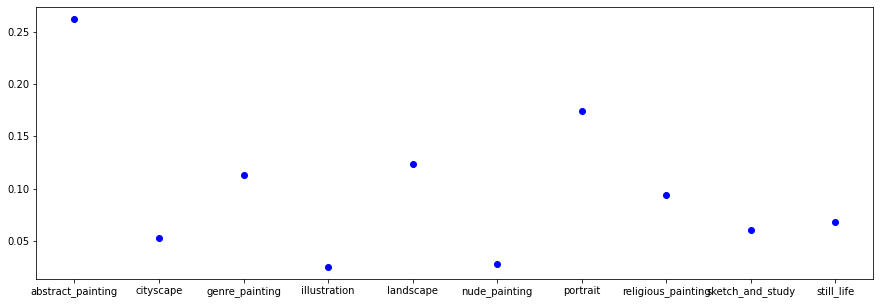

In [34]:
mov_bas=pd.DataFrame(df_train.groupby(by='genre')['file_name'].count()/df_train.shape[0]).reset_index()
plt.figure(figsize=(15, 5))
plt.scatter(x=mov_bas['genre'],y=mov_bas['file_name'],c='b');

## Mean color baseline

In [127]:
test=df_train['file_name'][df_train['movement']=='realism']
test[0:5]

571           realism_fyodor-vasilyev_summer-hot-day.jpg
519    realism_boris-kustodiev_portrait-of-o-p-myasoe...
539    realism_vincent-van-gogh_sien-with-cigar-sitti...
542             realism_edouard-manet_the-fifer-1866.jpg
593    realism_vasily-perov_portrait-avdotya-kuznetso...
Name: file_name, dtype: object

In [142]:
test.shape

(63,)

In [136]:


pixels=np.empty(3)
for file in list(test):
#pixels are stacked next to each other
    path=MAIN_PATH+IMAGES+'/'+file
    img=plt.imread(path)
    img_pixel = np.float32(img.reshape(-1, 3))
    pixels=np.vstack((pixels,img_pixel))
    
avg_color=pixels.mean(axis=0)
#pixels.shape  


In [83]:
pixels2.shape

(159360, 3)

In [139]:
#Recherche couleur dominante par méthode des kmoyens (sur 5 couleurs)
pixels=np.float32(pixels)
import cv2 # requires pip install opencv-python
n_colors = 5
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, .5)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
_, counts = np.unique(labels, return_counts=True)
dom_color = palette[np.argmax(counts)]

In [140]:
dom_color

array([33.071487, 24.548716, 20.182127], dtype=float32)

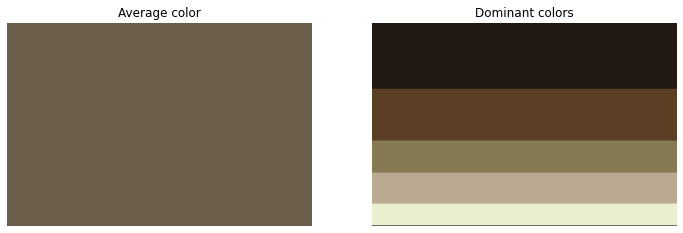

array([  0, 123, 220, 280, 338, 379])

In [141]:
import matplotlib.pyplot as plt

#on prend la taille de l'image d'origine, remplie de 1 et on applique la couleur moyenne
avg_patch = np.ones(shape=img1.shape, dtype=np.uint8)*np.uint8(avg_color)

indices = np.argsort(counts)[::-1]   
freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
rows = np.int_(img1.shape[0]*freqs)

dom_patch = np.zeros(shape=img1.shape, dtype=np.uint8)
for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.imshow(avg_patch)
ax0.set_title('Average color')
ax0.axis('off')
ax1.imshow(dom_patch)
ax1.set_title('Dominant colors')
ax1.axis('off')
plt.show(fig)
rows